<a href="https://colab.research.google.com/github/franckepeixoto/Pandas-IA-Generativa-e-LlamaIndex/blob/main/Construindo_um_Agente_RAG_para_An%C3%A1lise_de_Empresas_do_Mercado_Financeiro_Uma_Abordagem_Baseada_em_IA_Generativa_e_Dados_Fundamentalistas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#⚙️ Construindo um Agente RAG para Análise de Empresas do Mercado Financeiro
📌 **Uma Abordagem Baseada em IA Generativa e Dados Fundamentalistas**

Imagine fazer análises comparativas de empresas com dados financeiros atualizados, acessando-os de forma rápida e com informações reais e atualizadas de uma fonte segura.

⏱️Hoje, quando precisamos avaliar uma empresa, precisamos abrir uma planilha, analisar valores, ver indicadores e acaba sendo uma tarefa bastante trabalhosa.!

###### 📦 Instalação dos seguintes bibliotecas

In [1]:
!pip install llama-index  -q
!pip install llama-index-core  -q
!pip install llama-index-llms-gemini  -q
!pip install arize-phoenix==2.2.1 pyvis  -q
!pip  install llama-index-experimental   -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

###### 🪞 Configurações e Observability


In [62]:
import os
from getpass import getpass
from llama_index.core import Settings
from llama_index.llms.gemini import Gemini
from llama_index.core.callbacks import CallbackManager
GOOGLE_API_KEY = getpass('GOOGLE_API_KEY: ')

llm = Gemini(api_key=GOOGLE_API_KEY,temperature=0)
callback_manager = CallbackManager()

Settings.callback_manager = callback_manager
Settings.llm = llm


GOOGLE_API_KEY: ··········


In [63]:
import logging
import sys
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

##### 🐼 Obtendo dados fundamentalistas e criando um DataFrame

Usaremos essa estrutura para consultas basicas, como descobrir o ticker de uma determinada empresa e etc...

Nesse caso, usaremos apenas algumas colunas:

* **P/L** = Preço da ação dividido pelo lucro por ação. O P/L é o número de anos que se levaria para reaver o capital aplicado na compra de uma ação, através do recebimento do lucro gerado pela empresa, considerando que esses lucros permaneçam constantes.
* **P/VP** = Preço da ação dividido pelo Valor Patrimonial por ação. Informa quanto o mercado está disposto a pagar sobre o Patrimônio Líquido da empresa
* **PSR** = Price Sales Ratio: Preço da ação dividido pela Receita Líquida por ação
* **Dividend Yield** = Dividendo pago por ação dividido pelo preço da ação. É o rendimento gerado para o dono da ação pelo pagamento de dividendos.
* **ROE** = Retorno sobre o Patrimônio Líquido: Lucro líquido dividido pelo Patrimônio Líquido
* **Patrim. Líq** = O patrimônio líquido representa os valores que os sócios ou acionistas têm na empresa em um determinado momento. No balanço patrimonial, a diferença entre o valor dos ativos e dos passivos e resultado de exercícios futuros representa o PL (Patrimônio Líquido), que é o valor contábil devido pela pessoa jurídica aos sócios ou acionistas.
* **Liq. Corr.** = Ativo Circulante dividido pelo Passivo Circulante: Reflete a capacidade de pagamento da empresa no curto prazo.
* **P/Ativo** = Preço da ação dividido pelos Ativos totais por ação.

In [121]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from typing import  Dict, List

def converter_dados(soup:BeautifulSoup = None,type_name:str="") -> List[Dict]:
  table = soup.find(lambda tag: tag.name=='table')
  header = table.findAll(lambda tag: tag.name=='thead')[0]
  _template_header = []
  _template_index = 0
  for  th in header.findAll('th'):
    _template_header.append({"index":_template_index,"title":th.text.strip()})
    _template_index = _template_index + 1

  rows= []
  body = table.findAll(lambda tag: tag.name=='tbody')[0]

  for  tr in body.findAll('tr'):
    row = {}
    for pos in _template_header:
      tds = tr.findAll('td')
      index = pos['index']
      title = pos['title']

      if index == 0:
        describe = tds[index].find('span')['title'].strip()
        row['Nome'] = describe
        ticker = tds[index].find('a').text.strip()
        row['Ticker'] = ticker
      else:
        row[title] = tds[index].text.strip()


    rows.append(dict(row))

  return rows

def obterDadosBasicos():
  url = "https://fundamentus.com.br/resultado.php"
  page = requests.get(url,headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3' })
  soup = BeautifulSoup(page.content, "html.parser")
  rows = converter_dados(soup)
  return rows

dados_basicos_fundamentalistas  = obterDadosBasicos()
df = pd.DataFrame.from_dict(dados_basicos_fundamentalistas, orient='columns')

cols_names = {'Nome':'nome_da_empresa', 'Ticker':'ticker',   'Cotação':'cotacao',
              'P/L':'preco_da_acao_dividido_pelo_lucro_por_acao',
              'P/VP':'preco_da_acão_dividido_pelo_valor_patrimonial_por_acao',
              'PSR':'preco_da_acão_dividido_pela_receita_liquida_por_acao',
              'Div.Yield':'dividendo_pago_por_acao',
              'ROE':'retorno_sobre_o_patrimonio_liquido',
              'Patrim. Líq':'patrimônio_liquido',
              'Liq. Corr.':'liquidez_corrente',
              'Liq.2meses':'liquidez_2meses',
              'P/Ativo':'preco_da_acão_dividido_pelo_ativos_totais_por_acao'}


cols = ['Nome' , 'Ticker' , 'Cotação', 'P/L','P/VP','PSR','Div.Yield','ROE','Patrim. Líq','Liq. Corr.','Liq.2meses','P/Ativo']

df = df[cols]
df.reset_index(drop=True, inplace=True)
df.sample(10)

,Nome,Ticker,Cotação,P/L,P/VP,PSR,Div.Yield,ROE,Patrim. Líq,Liq. Corr.,Liq.2meses,P/Ativo
532,TRANSMISSÃO PAULISTA,TRPL4,"25,24","6,08","0,92","2,511","8,73%","15,18%","18.016.200.000,00","3,08","76.104.100,00","0,438"
322,AES SUL DISTRIB. GAÚCHA DE ENERGIA S.A.,AESL4,"10.081,90","0,00","2,26","0,000","0,00%","0,00%","5.030.750.000,00","0,94","0,00","0,632"
649,TAURUS ARMAS,TASA4,"11,28","9,35","1,31","0,802","3,58%","13,99%","1.091.810.000,00","1,49","4.793.260,00","0,663"
502,MONTEIRO ARANHA,MOAR3,"390,00","5,44","3,15","0,000","7,92%","58,01%","1.515.160.000,00","4,86","24.647,10","1,634"
172,GRUPO SOMA,SOMA3,"5,63","-2,67","0,76","0,822","0,00%","-28,52%","5.809.620.000,00","2,36","88.913.000,00","0,460"
731,PETTENATI,PTNT3,"10,22","12,36","1,31","0,638","2,08%","10,59%","375.241.000,00","2,50","14.906,80","0,593"
954,TELEMAR,TMAR6,"42,01","112,59","0,71","0,519","0,00%","0,63%","20.448.500.000,00","1,62","0,00","0,181"
967,CELPE,CEPE6,"43,00","200,52","1,97","0,379","0,00%","0,98%","1.632.000.000,00","1,17","0,00","0,221"
283,CIMOB,GAFP4,"0,05","-0,02","-0,01","0,155","0,00%","38,79%","-80.712.500,00","0,51","0,00","0,006"
32,BRASIL TELECOM PARTICIPAÇÕES S.A.,BRTP3,"35,71","-67,26","2,45","1,168","0,00%","-3,64%","5.302.340.000,00","1,29","0,00","0,684"


In [73]:
#Preparando os dados para serem usados em consultas
df = df.copy()
def fn_float(v) -> float:
  v = str(v).strip()
  v = v.replace('%','')
  v = v.replace(' ','')
  v = v.replace('.','')
  v = v.replace(',','.')
  v = v.replace('\n','').replace('\r','').strip()
  return float(v)#/100
def fn_percent(v) -> float:
  return fn_float(v)/100
if str(df['Liq.2meses'].dtype)=='object':
  df['Liq.2meses'] = df['Liq.2meses'].transform(lambda v:fn_float(v))
df = df[df['Liq.2meses']>0]

for col in ['ROE','Div.Yield']:
  if str(df[col].dtype)=='object':
    df[col]= df[col].transform(lambda v:fn_percent(v))

for col in ['Cotação','P/L', 'P/VP','PSR','P/Ativo','Liq. Corr.',   'Patrim. Líq']:
  if str(df[col].dtype)=='object':
    df[col]= df[col].transform(lambda v:fn_float(v))

df['Nome']= df['Nome'].transform(lambda v:str(v).strip().upper())

print("Dados prontos para serem usados em modo consulta")
print(df.head(1).T)

Dados prontos para serem usados em modo consulta
                       12
Nome         WDC NETWORKS
Ticker              LVTC3
Cotação              4.17
P/L               -360.97
P/VP                 0.42
PSR                 0.311
Div.Yield             0.0
ROE               -0.0012
Patrim. Líq   640698000.0
Liq. Corr.           2.37
Liq.2meses        63282.0
P/Ativo             0.192


##### 🔗 **Criação do Pipeline de Consulta**
Criaremos o seguinte Pipeline:

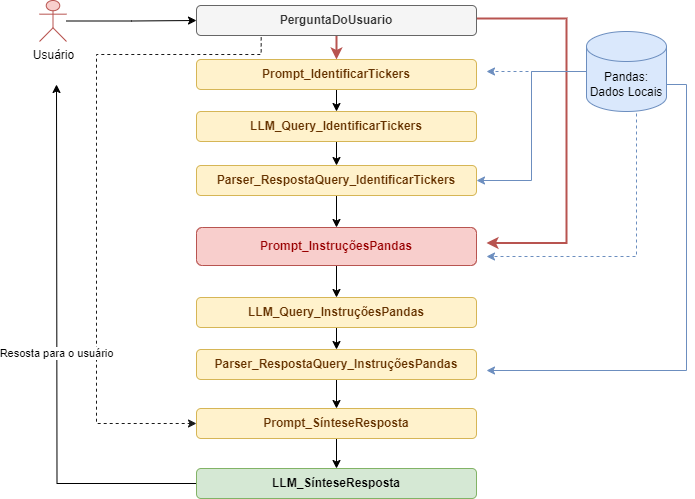

📌 **PerguntaDoUsuario**

Nosso primeiro bloco será um  **InputComponent()** usado para capturar as perguntas do usuário.

In [74]:
from llama_index.experimental.query_engine.pandas import PandasInstructionParser
from llama_index.core.prompts import PromptTemplate
from llama_index.core.query_pipeline import QueryPipeline, Link, InputComponent,ArgPackComponent
pergunta_do_usuario =  InputComponent()
print(pergunta_do_usuario)

partial_dict={}


📌 **Identificar Tickers**:
Agora iremos criar as intruções para  identificar no questionamento do usuário, qual empresa ou  empresas ele está falando e assim, identificarmos seus respectivos tickers

In [105]:
instrucoes_identificar_tickesr_str = (
    "1. Converta a consulta em código Python executável usando Pandas.\n"
    "2. Identifique qual  ticker a consulta se refere.\n"
    "2. Somente retorne os valores da coluna Ticker.\n"
    "3. Os tickers deve ser informado em formato de lista.\n"
    "4. IMPRIMA APENAS A EXPRESSÃO.\n"
    "5. Não coloque a expressão entre aspas.\n"
    "6. O dataframe possui as seguintes colunas: `{colunas_str}`\n"
    "7. Crie variações de nomes para encontrar os tickers em sua  expressão contains.\n"
    "8. Use sempre as intruções `case=False, na=False` nas clausulas contains.\n"
    "9. A última linha de código deve ser uma expressão Python que pode ser chamada com a função `eval()`.\n"
    "10. Sempre retorne a Coluna Ticker em formato de lista.\n\n"
    "----------------------------\n"
    "identique os tickers na consulta: {query_str}\n\n"
    "Expressão:"
)
prompt_identificar_tickers = PromptTemplate(instrucoes_identificar_tickesr_str).partial_format(colunas_str=str(list(df.columns)))
print(prompt_identificar_tickers)

metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>} template_vars=['colunas_str', 'query_str'] kwargs={'colunas_str': "['Nome', 'Ticker', 'Cotação', 'P/L', 'P/VP', 'PSR', 'Div.Yield', 'ROE', 'Patrim. Líq', 'Liq. Corr.', 'Liq.2meses', 'P/Ativo']"} output_parser=None template_var_mappings=None function_mappings=None template='1. Converta a consulta em código Python executável usando Pandas.\n2. Identifique qual  ticker a consulta se refere.\n2. Somente retorne os valores da coluna Ticker.\n3. Os tickers deve ser informado em formato de lista.\n4. IMPRIMA APENAS A EXPRESSÃO.\n5. Não coloque a expressão entre aspas.\n6. O dataframe possui as seguintes colunas: `{colunas_str}`\n7. Crie variações de nomes para encontrar os tickers em sua  expressão contains.\n8. Use sempre as intruções `case=False, na=False` nas clausulas contains.\n9. A última linha de código deve ser uma expressão Python que pode ser chamada com a função `eval()`.\n10. Sempre retorne a Coluna Ticker em formato de lista

📌 **Instruções Pandas**:
Após identificar quais tickers fazem parte da intenção do usuário, usaremos essas informações para criar uma nova consulta mais direcionada no pandas.

In [111]:
instrucoes_pandas_str = (
    "Você está trabalhando com um dataframe do pandas em Python.\n"
    "O nome do dataframe é `df`.\n"
    "Este é o resultado de `print(df.head(50))`:\n"
    "Sempre use os Tickers identificados como base nas clausulas em seu filtro.\n"
    "Sempre retorne em juntamente com as colunas de valores a coluna Ticker!\n"
    "Use sempre a clausua contrains na lista todos os Tickers.\n"
    "Siga estas instruções:\n"
    "1. Converta a consulta em código Python executável usando Pandas.\n"
    "2. A última linha de código deve ser uma expressão Python que pode ser chamada com a função `eval()`.\n"
    "3. O código deve representar uma solução para a consulta.\n"
    "4. IMPRIMA APENAS A EXPRESSÃO.\n"
    "5. Não coloque a expressão entre aspas.\n\n"
    "6. Use a listagem dos Tickers identificados  `{resultado_parse_tickers}` na clausula de filtro contains.\n\n"
    "Consulta: {query_str}\n\n"
    "Expressão:"
)
prompt_instrucoes_pandas = PromptTemplate(instrucoes_pandas_str).partial_format(query_str="analise")
print(prompt_instrucoes_pandas)

metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>} template_vars=['resultado_parse_tickers', 'query_str'] kwargs={'query_str': 'analise'} output_parser=None template_var_mappings=None function_mappings=None template='Você está trabalhando com um dataframe do pandas em Python.\nO nome do dataframe é `df`.\nEste é o resultado de `print(df.head(50))`:\nSempre use os Tickers identificados como base nas clausulas em seu filtro.\nSempre retorne em juntamente com as colunas de valores a coluna Ticker!\nUse sempre a clausua contrains na lista todos os Tickers.\nSiga estas instruções:\n1. Converta a consulta em código Python executável usando Pandas.\n2. A última linha de código deve ser uma expressão Python que pode ser chamada com a função `eval()`.\n3. O código deve representar uma solução para a consulta.\n4. IMPRIMA APENAS A EXPRESSÃO.\n5. Não coloque a expressão entre aspas.\n\n6. Use a listagem dos Tickers identificados  `{resultado_parse_tickers}` na clausula de filtro contains.\n\

📌 **Sintese Resposta**:
Por último, reunimos todas as informações catalogadas nas etapas anteriores para gerar um prompt mais  refinado e aderente ao contexto.

In [112]:
sintese_resposta_str = (

    "Você é um expert em investimentos, sempre responda de forma amigavel e bem didatico!\n"
    "Sempre responda com bom humor  e de forma educada!\n"
    "Siga estas instruções:\n"
    "1. Sempre informe o ticker das empresas em analise!\n"
    "2. Ao Final da resposta, faça um resumo com os pontos importantes da analise!\n"
    "3. Sempre use valor contindos na Saída do Pandas.\n"
    "4. Só responda com valors contidos na Saída do Pandas.\n\n"
    "Dada uma pergunta de entrada, sintetize uma resposta a partir dos resultados da consulta.\n"
    "Consulta: {query_str}\n\n"
    "Instruções do Pandas (opcional):\n{resposta_instrucoes_pandas}\n\n"
    "Tickers identificados: {resultado_parse_tickers}\n\n"
    "Saída do Pandas: {resultado_parse_pandas}\n\n"

    "Resposta: "
)

prompt_sintese_resposta = PromptTemplate(sintese_resposta_str)
print(prompt_sintese_resposta)

metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>} template_vars=['query_str', 'resposta_instrucoes_pandas', 'resultado_parse_tickers', 'resultado_parse_pandas'] kwargs={} output_parser=None template_var_mappings=None function_mappings=None template='Você é um expert em investimentos, sempre responda de forma amigavel e bem didatico!\nSempre responda com bom humor  e de forma educada!\nSiga estas instruções:\n1. Sempre informe o ticker das empresas em analise!\n2. Ao Final da resposta, faça um resumo com os pontos importantes da analise!\n3. Sempre use valor contindos na Saída do Pandas.\n4. Só responda com valors contidos na Saída do Pandas.\n\nDada uma pergunta de entrada, sintetize uma resposta a partir dos resultados da consulta.\nConsulta: {query_str}\n\nInstruções do Pandas (opcional):\n{resposta_instrucoes_pandas}\n\nTickers identificados: {resultado_parse_tickers}\n\nSaída do Pandas: {resultado_parse_pandas}\n\nResposta: '


🧩 Juntanto todos os blocos usando **QueryPipeline**



In [113]:
from IPython.display import display, Markdown
#Antes vamos criar nosso parse Pandas para nosso dataframe
output_pandas_parser = PandasInstructionParser(df)

p = QueryPipeline(
    modules={

        "Pergunta_do_Usuario": pergunta_do_usuario,

        "Prompt_IdentificarTickers": prompt_identificar_tickers,
        "LLM_Query_IdentificarTickers": llm, #" usaremos nossa LLM Gemini Pro
        "Parser_RespostaQuery_IdentificarTickers":output_pandas_parser,

        "Prompt_InstruçõesPandas":prompt_instrucoes_pandas,
        "LLM_Query_InstruçõesPandas": llm,
        "Parser_RespostaQuery_InstruçõesPandas": output_pandas_parser,

        "Prompt_SínteseResposta": prompt_sintese_resposta,
        "LLM_SínteseResposta": llm,

      },
    verbose=True,
)


p.add_chain([ "Pergunta_do_Usuario","Prompt_IdentificarTickers", "LLM_Query_IdentificarTickers", "Parser_RespostaQuery_IdentificarTickers" ])
p.add_chain(["Pergunta_do_Usuario", "Prompt_InstruçõesPandas","LLM_Query_InstruçõesPandas","Parser_RespostaQuery_InstruçõesPandas" ])

p.add_links([

    Link("Parser_RespostaQuery_IdentificarTickers", "Prompt_InstruçõesPandas", dest_key="resultado_parse_tickers"),
    Link("Pergunta_do_Usuario", "Prompt_SínteseResposta", dest_key="query_str"),
    Link("LLM_Query_InstruçõesPandas", "Prompt_SínteseResposta", dest_key="resposta_instrucoes_pandas"),
    Link("Parser_RespostaQuery_InstruçõesPandas", "Prompt_SínteseResposta", dest_key="resultado_parse_pandas"),
    Link("Parser_RespostaQuery_IdentificarTickers", "Prompt_SínteseResposta", dest_key="resultado_parse_tickers"),



])

p.add_link("Prompt_SínteseResposta", "LLM_SínteseResposta")


🧰 Pipeline pronto, vamos testar!

In [114]:
pergunta = "me diga o ROE e cotacao além da oscilacao nos ultimos anos da vale e americanas"
resposta = p.run(query_str=pergunta)
display(Markdown(resposta.message.content))

> Running module Pergunta_do_Usuario with input: 
query_str: me diga o ROE e cotacao além da oscilacao nos ultimos anos da vale e americanas

> Running module Prompt_IdentificarTickers with input: 
query_str: me diga o ROE e cotacao além da oscilacao nos ultimos anos da vale e americanas

> Running module LLM_Query_IdentificarTickers with input: 
messages: 1. Converta a consulta em código Python executável usando Pandas.
2. Identifique qual  ticker a consulta se refere.
2. Somente retorne os valores da coluna Ticker.
3. Os tickers deve ser informado em ...

> Running module Parser_RespostaQuery_IdentificarTickers with input: 
input: assistant: df[df['Nome'].str.contains('vale', case=False, na=False) | df['Nome'].str.contains('americanas', case=False, na=False)]['Ticker'].tolist()

> Running module Prompt_InstruçõesPandas with input: 
resultado_parse_tickers: ['AMER3', 'VALE3']

> Running module LLM_Query_InstruçõesPandas with input: 
messages: Você está trabalhando com um dataframe do 

**Cotação e ROE**

* **VALE3 (Vale):**
    * Cotação: R$ 64,29
    * ROE: 20,68%

* **AMER3 (Americanas):**
    * Cotação: R$ 0,53
    * ROE: 54,76%

**Oscilação nos Últimos Anos**

Infelizmente, a saída do Pandas não contém informações sobre a oscilação nos últimos anos.

**Resumo**

* A Vale (VALE3) tem uma cotação mais alta e um ROE menor do que a Americanas (AMER3).
* A Americanas tem uma cotação mais baixa e um ROE maior do que a Vale.
* A saída do Pandas não fornece informações sobre a oscilação nos últimos anos.

🛑 As oscilações nos últimos anos **não estão disponíveis na saída do Pandas.**

Observe que a analise foi quase perfeita, por ter somente uma fonte de dados local, que em nosso caso, é o dataframe pandas, com isso, ele não foi capaz de nos dar informaçoes sobre oscilação.
isso é algo possitivo, pois o a IA generativa não inventou um valor para a oscilação com base nas demais colunas.

---

Para suprir essa limitação, iremos por em nosso diagrama um modulo com conectividade a internet  e para isso, usaremos o módulo Retriever para construirmos nos acesso ao Fundamentus.
Mais informações sobre **Retrivers**?  https://docs.llamaindex.ai/en/stable/module_guides/querying/retriever/retrievers/



In [115]:
from typing import Optional,Dict,List
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import NodeWithScore, QueryBundle, TextNode
from llama_index.core.schema import Document

class FundamentusRetriever(BaseRetriever):
  """Fundamentus Pesquisar mais detalhada em função dos tickers capturados"""

  spec_functions = ["get_oscilacoes"]

  def __init__(self,callback_manager: Optional[CallbackManager] = None) -> None:
      """Initialize with parameters."""
      super().__init__(callback_manager)


  def _retrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
    nodes = []
    content=""
    for ticker in eval(query_bundle.query_str):
      result = self.get_oscilacoes(ticker)
      content = content + f"# Oscilação de {ticker}:\n\r"
      for item in result:
        content = content + f"{item}\n\r"
      content = content + "-------------\n\r"
    nodes.append(NodeWithScore(node=TextNode(text=content, score=1.0)))
    query_bundle.nodes = nodes

    return nodes #{'output': ' | '.join(nodes) }
  def __consulta_ao_site_fundamentus(self, ticker :str) -> List[str]:
    url = f"https://fundamentus.com.br/detalhes.php?papel={ticker}"
    page = requests.get(url,headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3' })
    soup = BeautifulSoup(page.content, "html.parser")
    oscilacoes = []
    tables = soup.findAll(lambda tag: tag.name=='table')
    for table in tables:
      trs = table.findAll('tr')
      target = trs[0].find('td').find('span').text.strip().lower()
      if target.find('oscilações')>=0:
        #oscilacoes
        for tr in trs[1:]:
          tds =  tr.findAll('td')
          if len(tds) >1:
            d = tds[0].find('span').text.strip()#.upper()
            v = tds[1].find('span').text.strip().upper()
            if v != '':
              oscilacoes.append(['No ' + d.lower()+' ' if len(d)== 3 else 'Em '+d.lower() ][0] +': '+ v)
    return oscilacoes
  def get_oscilacoes(self, ticker: str):
    search_hits = self.__consulta_ao_site_fundamentus(ticker)
    return search_hits

Após criarmos nosso Retriever  **FundamentusRetriever** , iremos testalo antes de adicionar em nosso pipeline!  :)

In [116]:
from llama_index.core.query_engine import RetrieverQueryEngine
fundamentus_retriever = FundamentusRetriever()
query_engine = RetrieverQueryEngine.from_args(fundamentus_retriever, llm=llm)
response = query_engine.query("['PETR4','VALE3','PETR3']")
print(response)

- PETR4: 106,66%
- VALE3: 0,31%
- PETR3: 93,68%



🔗 **Atualizando Pipeline**

Adicionaremos  nosso Retriever com a função de obter dados externos para deixar as respostas de nosso RAG mais efetivo.

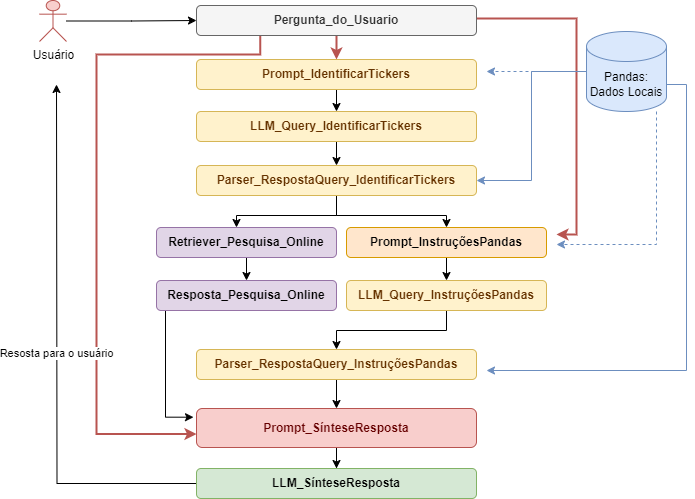

📌 Aterando o bloco **Sintese Resposta**:
Precisamos informar ao prompt de sintese de resposta o resultado proveniente do site fundamentus.

In [117]:
sintese_resposta_str = (

    "Você é um expert em investimentos, sempre responda de forma amigavel e bem didatico!\n"
    "Sempre responda com bom humor  e de forma educada!\n"
    "Siga estas instruções:\n"
    "1. Sempre informe o ticker das empresas em analise!\n"
    "2. Ao Final da resposta, faça um resumo com os pontos importantes da analise!\n"
    "3. Sempre use valor contindos na Saída do Pandas.\n"
    "4. Só responda com valors contidos na Saída do Pandas.\n\n"
    "Dada uma pergunta de entrada, sintetize uma resposta a partir dos resultados da consulta.\n"
    "Consulta: {query_str}\n\n"
    "Instruções do Pandas (opcional):\n{resposta_instrucoes_pandas}\n\n"
    "Tickers identificados: {resultado_parse_tickers}\n\n"
    "Complemento para analise: {resposta_dados_online}\n\n"
    "Saída do Pandas: {resultado_parse_pandas}\n\n"

    "Resposta: "
)

prompt_sintese_resposta = PromptTemplate(sintese_resposta_str)
print(prompt_sintese_resposta)

metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>} template_vars=['query_str', 'resposta_instrucoes_pandas', 'resultado_parse_tickers', 'resposta_dados_online', 'resultado_parse_pandas'] kwargs={} output_parser=None template_var_mappings=None function_mappings=None template='Você é um expert em investimentos, sempre responda de forma amigavel e bem didatico!\nSempre responda com bom humor  e de forma educada!\nSiga estas instruções:\n1. Sempre informe o ticker das empresas em analise!\n2. Ao Final da resposta, faça um resumo com os pontos importantes da analise!\n3. Sempre use valor contindos na Saída do Pandas.\n4. Só responda com valors contidos na Saída do Pandas.\n\nDada uma pergunta de entrada, sintetize uma resposta a partir dos resultados da consulta.\nConsulta: {query_str}\n\nInstruções do Pandas (opcional):\n{resposta_instrucoes_pandas}\n\nTickers identificados: {resultado_parse_tickers}\n\nComplemento para analise: {resposta_dados_online}\n\nSaída do Pandas: {resultado_p

🧩 Juntanto todos os blocos usando **QueryPipeline** Novamente :)

In [118]:
p = QueryPipeline(
    modules={

        "Pergunta_do_Usuario": pergunta_do_usuario,

        "Prompt_IdentificarTickers": prompt_identificar_tickers,
        "LLM_Query_IdentificarTickers": llm, #" usaremos nossa LLM Gemini Pro
        "Parser_RespostaQuery_IdentificarTickers":output_pandas_parser,

        "Prompt_InstruçõesPandas":prompt_instrucoes_pandas,
        "LLM_Query_InstruçõesPandas": llm,
        "Parser_RespostaQuery_InstruçõesPandas": output_pandas_parser,

        "Retriever_Pesquisa_Online":fundamentus_retriever,
        "Resposta_Pesquisa_Online":ArgPackComponent(),
        "Prompt_SínteseResposta": prompt_sintese_resposta,
        "LLM_SínteseResposta": llm,

      },
    verbose=True,
)


p.add_chain([ "Pergunta_do_Usuario","Prompt_IdentificarTickers", "LLM_Query_IdentificarTickers", "Parser_RespostaQuery_IdentificarTickers" ])
p.add_chain(["Pergunta_do_Usuario", "Prompt_InstruçõesPandas","LLM_Query_InstruçõesPandas","Parser_RespostaQuery_InstruçõesPandas" ])

p.add_links([

    Link("Parser_RespostaQuery_IdentificarTickers", "Prompt_InstruçõesPandas", dest_key="resultado_parse_tickers"),
    Link("Pergunta_do_Usuario", "Prompt_SínteseResposta", dest_key="query_str"),
    Link("Parser_RespostaQuery_IdentificarTickers", "Retriever_Pesquisa_Online"),
    Link("Retriever_Pesquisa_Online", "Resposta_Pesquisa_Online", dest_key="query_nodes"),

    Link("Resposta_Pesquisa_Online", "Prompt_SínteseResposta", dest_key="resposta_dados_online"),
    Link("LLM_Query_InstruçõesPandas", "Prompt_SínteseResposta", dest_key="resposta_instrucoes_pandas"),
    Link("Parser_RespostaQuery_InstruçõesPandas", "Prompt_SínteseResposta", dest_key="resultado_parse_pandas"),
    Link("Parser_RespostaQuery_IdentificarTickers", "Prompt_SínteseResposta", dest_key="resultado_parse_tickers"),



])

p.add_link("Prompt_SínteseResposta", "LLM_SínteseResposta")


🧰 Pipeline pronto, vamos testar novamente!


In [119]:
pergunta = "me diga o ROE e cotacao além da oscilacao nos ultimos anos da vale e americanas"
resposta = p.run(query_str=pergunta)
display(Markdown(resposta.message.content))

> Running module Pergunta_do_Usuario with input: 
query_str: me diga o ROE e cotacao além da oscilacao nos ultimos anos da vale e americanas

> Running module Prompt_IdentificarTickers with input: 
query_str: me diga o ROE e cotacao além da oscilacao nos ultimos anos da vale e americanas

> Running module LLM_Query_IdentificarTickers with input: 
messages: 1. Converta a consulta em código Python executável usando Pandas.
2. Identifique qual  ticker a consulta se refere.
2. Somente retorne os valores da coluna Ticker.
3. Os tickers deve ser informado em ...

> Running module Parser_RespostaQuery_IdentificarTickers with input: 
input: assistant: df[df['Nome'].str.contains('vale', case=False, na=False) | df['Nome'].str.contains('americanas', case=False, na=False)]['Ticker'].tolist()

> Running module Prompt_InstruçõesPandas with input: 
resultado_parse_tickers: ['AMER3', 'VALE3']

> Running module Retriever_Pesquisa_Online with input: 
input: ['AMER3', 'VALE3']

> Running module LLM_Query

**VALE3**

* ROE: 20,68%
* Cotação: R$ 64,29
* Oscilação:
    * No dia: -0,34%
    * No mês: 0,61%
    * Em 30 dias: 2,78%
    * Em 12 meses: 0,31%

**AMER3**

* ROE: 54,76%
* Cotação: R$ 0,53
* Oscilação:
    * No dia: 0,00%
    * No mês: -3,64%
    * Em 30 dias: -8,62%
    * Em 12 meses: -52,68%

**Resumo:**

* A VALE3 tem um ROE maior que a AMER3, indicando maior rentabilidade.
* A cotação da VALE3 é significativamente maior que a da AMER3.
* A AMER3 tem apresentado uma oscilação negativa mais acentuada nos últimos anos em comparação com a VALE3.


*   https://docs.llamaindex.ai/en/stable/examples/pipeline/query_pipeline/
*   https://docs.llamaindex.ai/en/latest/examples/agent/introspective_agent_toxicity_reduction/

*   https://docs.llamaindex.ai/en/stable/examples/pipeline/query_pipeline_pandas/?h=querypipeline

*   https://docs.llamaindex.ai/en/stable/examples/pipeline/query_pipeline_memory/?h=querypipeline
*   https://docs.llamaindex.ai/en/stable/api_reference/retrievers/


